In [74]:
import pandas as pd
from warnings import filterwarnings
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
import numpy as np
filterwarnings('ignore')
%matplotlib inline

# Helper Functions

In [85]:
def missing_values(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(
        ascending = False)
    missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data.head(10)

def get_column_type(data):
    obj = []
    int_cont = []
    for name in data.columns:
        if data[name].dtype is np.dtype('O') and name != 'source':
            obj.append(name)
        else:
            int_cont.append(name)
    return obj, int_cont


def get_counts(data, columns):
    for name in columns:
        print(name.upper())
        print(data[name].value_counts())

def dummy_data(data, todummy_list):
    for x in todummy_list:
        dummies = pd.get_dummies(data[x], prefix=x, dummy_na=False)
        data = data.drop(x, 1)
        data = pd.concat([data, dummies], axis=1)
    return data

def revertBack(data, target):
    train = data.loc[data['source']=='train']
    test = data.loc[data['source']=='test']
    train.drop('source',axis=1,inplace=True)
    test.drop(['source',target],axis=1,inplace=True)
    return train, test

def plot_confusion_matrix(cm, names, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    fmt =  'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True Lable')
    plt.xlabel('Predicted Label')
    plt.show()

In [51]:
train = pd.read_csv('training.csv')
test = pd.read_csv('test.csv')
train['source']= 'train'
test['source'] = 'test'
data=pd.concat([train, test],ignore_index=True)
data.shape

(140681, 17)

In [52]:
to_drop = ['CountryCode','CurrencyCode','ProductId','Value','TransactionId']
data.drop(to_drop,1,inplace=True)

In [53]:
data['TransactionStartTime'] = pd.to_datetime(data['TransactionStartTime'])
data['year'] = data['TransactionStartTime'].dt.year
data['month'] = data['TransactionStartTime'].dt.month
data['day'] = data['TransactionStartTime'].dt.day_name()
data['hour'] = data['TransactionStartTime'].dt.hour

data.drop('TransactionStartTime', 1, inplace=True)

In [54]:
data.head(5)

,AccountId,Amount,BatchId,ChannelId,CustomerId,FraudResult,PricingStrategy,ProductCategory,ProviderId,SubscriptionId,source,year,month,day,hour
0,AccountId_3957,1000.0,BatchId_36123,ChannelId_3,CustomerId_4406,0.0,2,airtime,ProviderId_6,SubscriptionId_887,train,2018,11,Thursday,2
1,AccountId_4841,-20.0,BatchId_15642,ChannelId_2,CustomerId_4406,0.0,2,financial_services,ProviderId_4,SubscriptionId_3829,train,2018,11,Thursday,2
2,AccountId_4229,500.0,BatchId_53941,ChannelId_3,CustomerId_4683,0.0,2,airtime,ProviderId_6,SubscriptionId_222,train,2018,11,Thursday,2
3,AccountId_648,20000.0,BatchId_102363,ChannelId_3,CustomerId_988,0.0,2,utility_bill,ProviderId_1,SubscriptionId_2185,train,2018,11,Thursday,3
4,AccountId_4841,-644.0,BatchId_38780,ChannelId_2,CustomerId_988,0.0,2,financial_services,ProviderId_4,SubscriptionId_3829,train,2018,11,Thursday,3


In [55]:
data['year'] = data.year.astype(str)
data['month'] = data.month.astype(str)
data['day'] = data.day.astype(str)
data['hour'] = data.hour.astype(str)

pending_test = ['SubscriptionId','CustomerId','BatchId','AccountId']
data.drop(pending_test,1,inplace=True)

In [56]:
data.head(2)

,Amount,ChannelId,FraudResult,PricingStrategy,ProductCategory,ProviderId,source,year,month,day,hour
0,1000.0,ChannelId_3,0.0,2,airtime,ProviderId_6,train,2018,11,Thursday,2
1,-20.0,ChannelId_2,0.0,2,financial_services,ProviderId_4,train,2018,11,Thursday,2


In [58]:
data = dummy_data(data, ['ChannelId','PricingStrategy','ProductCategory','ProviderId', 'year', 'month', 
                         'day', 'hour'])

In [59]:
train, test = revertBack(data, 'FraudResult')

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [61]:
feat = [col for col in train.columns if col not in ['FraudResult']]
X = train[feat]
y = train['FraudResult']
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [62]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 144
Before OverSampling, counts of label '0': 66819 

After OverSampling, the shape of train_X: (133638, 64)
After OverSampling, the shape of train_y: (133638,) 

After OverSampling, counts of label '1': 66819
After OverSampling, counts of label '0': 66819


In [66]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, auc, roc_auc_score, roc_curve, recall_score, classification_report

parameters = {
    'C': np.linspace(1, 10, 10)
             }
lr = LogisticRegression()
clf = GridSearchCV(lr, parameters, cv=5, verbose=5, n_jobs=3)
clf.fit(X_train_res, y_train_res.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    6.5s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:   22.1s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=3,
             param_grid={'C': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=5)

In [68]:
lr1 = LogisticRegression(C=1,penalty='l1', verbose=5)
lr1.fit(X_train_res, y_train_res.ravel())

[LibLinear]

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=5,
                   warm_start=False)

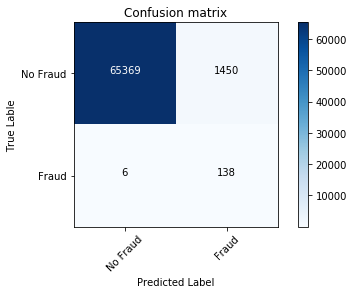

F1-Score metric in the testing dataset: 0.9782566491943313%


In [80]:
y_train_pre = lr1.predict(X_train)

cnf_matrix_tra = confusion_matrix(y_train, y_train_pre)
title = 'Confusion matrix'
target_names = ['No Fraud', 'Fraud']
plot_confusion_matrix(cnf_matrix_tra, target_names,title)
print("F1-Score metric in the testing dataset: {}%".format(f1_score(y_train, y_train_pre)))

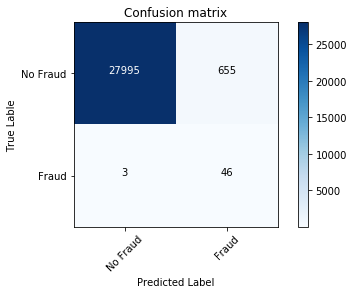

F1-Score metric in the testing dataset: 0.12266666666666666%


In [86]:
y_pre = lr1.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pre)
title = 'Confusion matrix'
target_names = ['No Fraud', 'Fraud']
plot_confusion_matrix(cnf_matrix, target_names,title)

print("F1-Score metric in the testing dataset: {}%".format(f1_score(y_test, y_pre)))

In [84]:
sub = pd.read_csv('SampleSubmission.csv')
sub['Product_Supermarket_Sales'] = clf.predict(test[feature_test])
sub.to_csv('six_sub.csv', index=False)

'Done!'

In [ ]:
result = lr1.predict(test[feat])
cnf_matrix_tra = confusion_matrix(y_train, y_train_pre)
title = 'Confusion matrix'
target_names = ['No Fraud', 'Fraud']
plot_confusion_matrix(cnf_matrix_tra, target_names,title)